In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [2]:
# Note: gym changed from version 0.7.3 to 0.8.0
# MointainCar episode lenght is capped at 200 in later versions.
# This means your agent can't learn as much in the aerleier episodes
# since they are no longer as long.

# Adapt Q-Learning script to use TD(lambda) method instead

import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime

# code we alredy wrote
from q_learning import plot_cost_to_go, FeatureTransformer, Model, plot_running_avg

In [3]:
class BaseModel:
    def __init__(self, D):
        self.w = np.random.randn(D) / np.sqrt(D)
        
    def partial_fit(self, input_, target, eligibility, lr= 10e-3):
        self.w += lr*(target - input_.dot(self.w)) * eligibility
        
    def predict(self, X):
        X = np.array(X)
        return X.dot(self.w)

In [8]:
# Holds one BaseModel for each action
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        
        D = feature_transformer.dimensions
        self.eligibilities = np.zeros((env.action_space.n, D))
        for i in range(env.action_space.n):
            model = BaseModel(D)
            self.models.append(model)
        
    def predict(self, s):
        X = self.feature_transformer.transform([s])
        assert(len(X.shape) == 2)
        return np.array([m.predict(X)[0] for m in self.models])

    def update(self, s, a, G, gamma, lambda_):
        X = self.feature_transformer.transform([s])
        assert(len(X.shape) == 2)
        self.eligibilities *= gamma * lambda_
        self.eligibilities[a] += X[0]
        self.models[a].partial_fit(X[0], G, self.eligibilities[a])
        
    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

In [10]:
# returns a list of states_and_rewards, and the total reward
def play_one(model, eps, gamma, lambda_):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done and iters < 10000:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        #update the model
        G = reward + gamma * np.max(model.predict(observation)[0])
        model.update(prev_observation, action, G, gamma, lambda_)
        
        totalreward += reward
        iters += 1
    
    return totalreward

episode: 0 total reward: -200.0
episode: 100 total reward: -162.0
episode: 200 total reward: -143.0
avg reward for last 100 episodes: -131.37
total steps: 43726.0


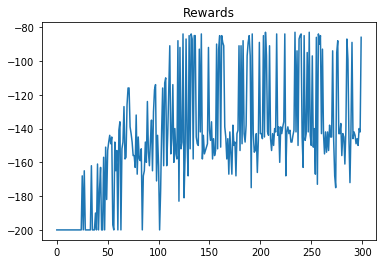

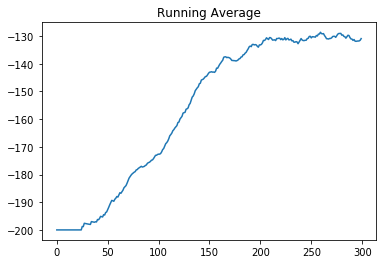

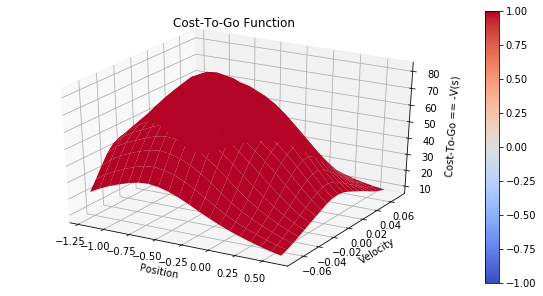

In [11]:
if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft)
    gamma = 0.99
    lambda_ = 0.7
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
        
    N = 300
    totalrewards = np.empty(N)
    costs = np.empty(N)
    for n in range(N):
        # eps = 1.0/(0.1*n+1)
        eps = 0.1*(0.97**n)
        totalreward = play_one(model, eps, gamma, lambda_)
        totalrewards[n] = totalreward
        if n % 100 == 0:
            print("episode:", n, "total reward:", totalreward)
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", -totalrewards.sum())
    
    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()
    
    plot_running_avg(totalrewards)
    
    # plot the optimal state-value function
    plot_cost_to_go(env, model)